In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import json

In [2]:
def remove_nonwords(text):
    non_words = re.compile(r"[^a-z']")
    processed_text = re.sub(non_words, ' ', text)
    return processed_text.strip()

def remove_stopwords(text):    
    stopwrds=stopwords.words('english')
    words = [word for word in text.split() if word not in stopwrds]
    return words

def stem_words(words):   
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

def preprocess_text(corpus):
    final_corpus=[]
    for text in corpus:
        processed_text = remove_nonwords(text.lower())
        words = remove_stopwords(processed_text)
        stemmed_words = stem_words(words)
        final_corpus.append(" ".join(stemmed_words))
    return final_corpus

def query_process(query):
    pr_q=remove_nonwords(query)
    pr_q_stp=remove_stopwords(pr_q)
    q_stem=stem_words(pr_q_stp)
    return " ".join(q_stem)

def print_related_docs(doc_vec,query_vec,corpus):
    cosineSim=cosine_similarity(doc_vector,query_vector).flatten()
    related_docs_inx=cosineSim.argsort()[:-len(corpus)-1:-1]
    print(f"Related documents per order : {related_docs_inx}")
    print(" ")
    print("TOP 5 RESULTS")
    print(" ")
    for i in range(5):
        print(corpus[related_docs_inx[i]],'\n')

In [3]:
data = pd.read_json('data_dic_data.json', lines=True)
data=data.T
data=data.rename(columns={0:"contents"})
data

,contents
https:/stackoverflow.com/questions/69553953/django-core-exceptions-fielderror-unknown-fields-phonenumber-city-email-k,django.core.exceptions.FieldError: Unknown fie...
https:/stackoverflow.com/questions/69553950/error-in-camera-app-type-error-null-on-getcontext,Error in camera App / Type error: null on 'get...
https:/stackoverflow.com/questions/69553949/equals-operator-difference,Equals operator difference Actual output 16461...
https:/stackoverflow.com/questions/69553947/how-to-test-react-application-bundled-in-webpack-that-uses-require-functions,How to test React application bundled in Webpa...
https:/stackoverflow.com/questions/69553945/nrows-alternative-for-read-sql-table,nrows alternative for read_sql_table I am a re...
...,...
https:/stackoverflow.com/questions/69547471/unity-submodule-for-core-code-across-multiple-projects,Unity Submodule for Core Code Across Multiple ...
https:/stackoverflow.com/questions/69547470/binding-class-to-material-table-data-in-react,Binding Class to Material-Table data in React ...
https:/stackoverflow.com/questions/69547469/optimise-mongodb-aggregate-query-performance,Optimise MongoDB aggregate query performance I...
https:/stackoverflow.com/questions/69547464/how-to-iterate-over-nested-array-of-object-in-typescript,How to iterate over nested array of object in ...


In [4]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data.contents)
text = tfidf.transform(data.contents)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


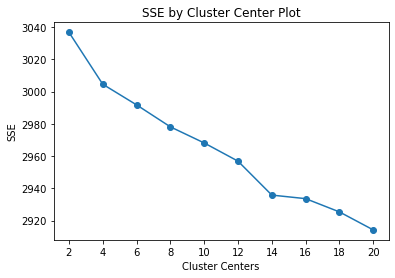

In [5]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [6]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=14)

In [8]:
clusters = kmeans.fit_predict(text)
clusters

array([12,  4,  9, ..., 11, 13,  6])

In [9]:
centroids=kmeans.cluster_centers_
centroids

array([[0.        , 0.        , 0.00099944, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00029603, 0.00185316, ..., 0.        , 0.        ,
        0.        ],
       [0.00105719, 0.        , 0.00197713, ..., 0.00177994, 0.00176849,
        0.        ],
       ...,
       [0.00991324, 0.00302378, 0.0068124 , ..., 0.00122431, 0.00235023,
        0.00501048],
       [0.        , 0.00018548, 0.        , ..., 0.        , 0.        ,
        0.00039505],
       [0.        , 0.        , 0.        , ..., 0.00570034, 0.00308077,
        0.        ]])

In [10]:
text[clusters==4]

<560x3578 sparse matrix of type '<class 'numpy.float64'>'
	with 20219 stored elements in Compressed Sparse Row format>

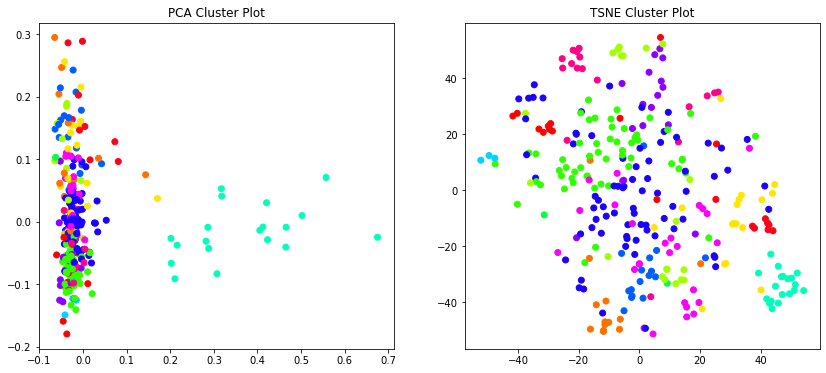

In [11]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [12]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
screen,code,using,video,ios,flutter,native,app,react,android

Cluster 1
mysql,columns,key,rows,id,query,column,tables,data,table

Cluster 2
code,value,use,json,like,class,string,list,type,object

Cluster 3
like,want,need,database,code,request,using,json,api,data

Cluster 4
running,version,code,command,using,app,application,server,run,error

Cluster 5
https,sheet,using,api,script,data,error,com,cloud,google

Cluster 6
overflow,update,editing,post,want,hours,improve,ago,question,closed

Cluster 7
file,server,run,error,image,dockerfile,nginx,container,compose,docker

Cluster 8
value,frame,rows,df,values,data,pandas,columns,dataframe,column

Cluster 9
way,work,method,component,want,like,using,use,function,code

Cluster 10
script,path,using,code,error,folder,directory,json,files,file

Cluster 11
filter,select,like,data,time,values,value,plot,query,date

Cluster 12
css,page,like,using,code,enter,description,images,text,image

Cluster 13
values,using,loop,use,like,code,want,arrays,

In [13]:
file="data_dic_data.json"
loaded_json=json.load(open(file))
pre_processed_corpus=[loaded_json[description] for description in loaded_json]
processed_corpus=preprocess_text(pre_processed_corpus)
vectorizerX=TfidfVectorizer()
vectorizerX.fit(processed_corpus)
doc_vector=vectorizerX.transform(processed_corpus)

In [14]:
user_query=input("Please give a query: ")
processed_query=[query_process(user_query)]
query_vector=vectorizerX.transform(processed_query)
print_related_docs(doc_vector,query_vector,pre_processed_corpus)

Related documents per order : [  89 1196 1522 ... 2009 2008    0]
 
TOP 5 RESULTS
 
Python - dump Python path configuration from command line? I just learned, that upon some errors, Python dumps its path configuration ; for instance, like in this snippet from Fatal Python error: init_fs_encoding: failed to get the Python codec of the filesystem encoding, when trying to start uwsgi : So, now I'm wondering - is there a command line switch, so I could just call, let's say something like python --dump-path-config, and it would print the above path configuration, and exit? I am aware that one could write a Python script that would perform the same task and run that - however, since this dump is apparently "built-in" in Python anyways, I was wondering if there was a way to use that machinery. ( Btw, I found Issue 38236: Dump the Python path configuration at the first import error - Python tracker - apparently this kind of dump exists only for Python 3.8 and 3.9 ) site design / logo © 2021 St